## Assignment 



###
1.	Build a classification model using logistic regression to predict the correct type of drug based on the given dataset. 
2.	Report the confusion matrix and compute the f-1 score
3.	Find out which variable has the highest impact on target variable

In [1]:
#load neccesary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm



In [2]:
df=pd.read_csv("drug_df.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
df.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [5]:
#numerical and categorical column
num_col=df.select_dtypes(include=np.number).columns
cat_col=df.select_dtypes(exclude=np.number).columns


##### inference -  
1) there are no missing values.
2) target varibale is a multiclass(5)


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Exploratory Data Analysis</h2>
</div>

In [6]:
#lets plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

ValueError: could not convert string to float: 'F'

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='count', ylabel='Drug'>

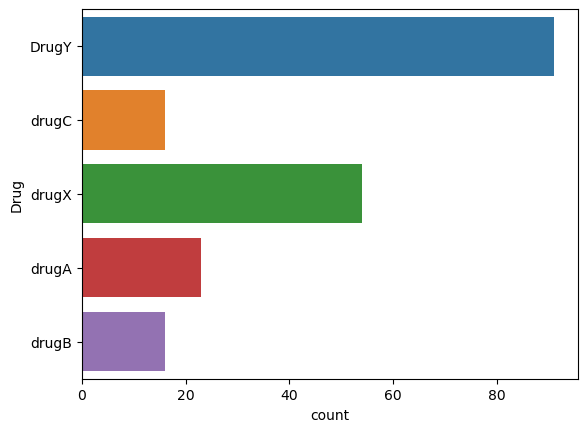

In [7]:
#lets check the y variable distribution to see if it is a unbalanced class

sns.countplot(y=df['Drug'],data=df)

### Inference - it looks, it has many minority class and shows class imbalance 

In [8]:
#lets do chisquare test to understand the relation between x(category variable ) and y(category variable)

#chiSquare (using scipy.stats) 
from IPython.display import display, HTML
from scipy.stats import chi2_contingency

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))



for col in cat_col:
    print(col)
    observed_fre=pd.crosstab(df[col],df['Drug'].astype('category'))
    stat,p,dof,expected_fre=chi2_contingency(observed_fre)
    print(f'chisquare value for {col} is {stat} and p-value is {p}, and dof {dof}')


Sex
chisquare value for Sex is 2.119248418109203 and p-value is 0.7138369773987128, and dof 4
BP
chisquare value for BP is 143.2328718496999 and p-value is 5.0417334144665895e-27, and dof 8
Cholesterol
chisquare value for Cholesterol is 19.609657681313475 and p-value is 0.0005962588389856497, and dof 4
Drug
chisquare value for Drug is 800.0000000000001 and p-value is 6.336427947937658e-160, and dof 16


##### inference - sex column is not statistically significant     

Text(0.5, 1.0, 'relation Sex vs Drug')

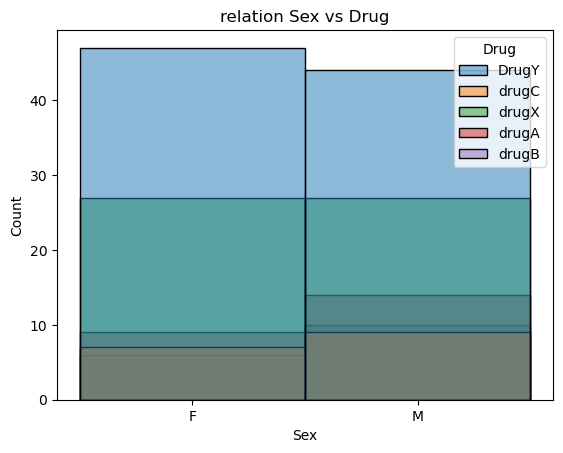

In [9]:
# sex vs Drug
sns.histplot(x=df['Sex'],bins=50,color='white',hue=df['Drug'])
plt.title("relation Sex vs Drug")

##### inference - all types of drugs are used for both sex , we can not conclude drugs prediction  for  sex column

Text(0.5, 1.0, 'relation BP vs Drug')

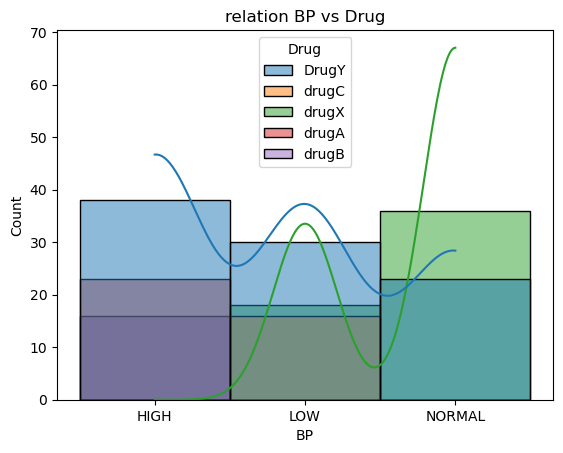

In [10]:
#BP vs Drug
sns.histplot(x=df['BP'],bins=5,color='white',hue=df['Drug'],kde=True)
plt.title("relation BP vs Drug")

##### inference - drug B  is only used for high BP patients and drug X is only for normal BP pateint  

Text(0.5, 1.0, 'relation Cholestrol vs Drug')

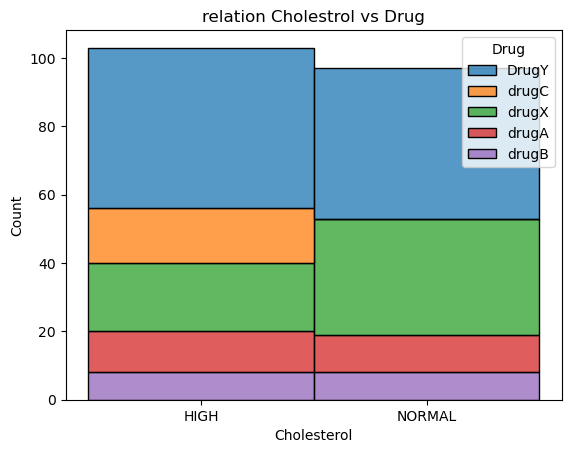

In [11]:
#cholestrol vs Drug
sns.histplot(x=df['Cholesterol'],bins=50,color='white',hue=df['Drug'],binwidth=.2,multiple='stack')
plt.title("relation Cholestrol vs Drug")

##### 

##### inference - drug c is only used for high cholestrol patients 

Text(0.5, 1.0, 'relation Cholestrol vs Drug')

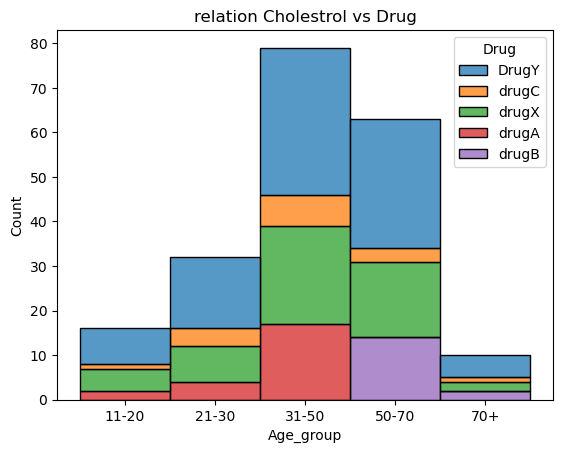

In [12]:
#age vs drug

#lets create a  age group
labels=['0-10','11-20','21-30','31-50','50-70','70+']
bins=[0,10,20,30,50,70,100]
df_age_grp=pd.DataFrame()
df_age_grp=df.copy()
df_age_grp['Age_group']=pd.cut(df_age_grp['Age'],bins=bins,labels=labels)
sns.histplot(x=df_age_grp['Age_group'],bins=100,multiple='stack',hue=df['Drug'])
plt.title("relation Cholestrol vs Drug")


<Axes: xlabel='Age', ylabel='Count'>

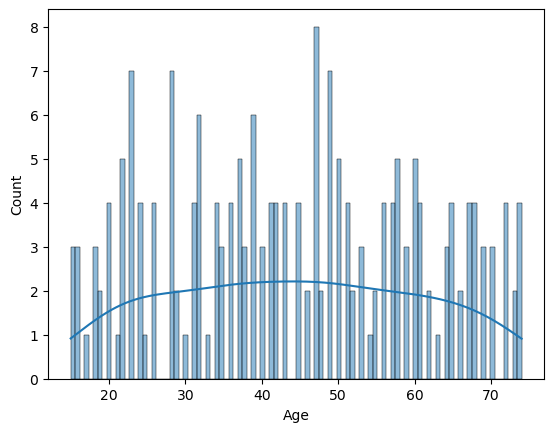

In [13]:
sns.histplot(data=df_age_grp,x='Age',bins=100,kde=True)

##### inference - drugs are not used for kids , drug B is only  used for patients having age above 50 (senior citizens) , drug A is not used for patients having age above 50

In [14]:
df_age_grp.groupby(['Age_group','BP'])['Drug'].value_counts()

Age_group  BP      Drug 
0-10       HIGH    DrugY    0
                   drugX    0
                   drugC    0
                   drugB    0
                   drugA    0
                           ..
70+        NORMAL  DrugY    1
                   drugC    0
                   drugB    0
                   drugA    0
                   drugX    0
Name: count, Length: 90, dtype: int64

<Axes: xlabel='Drug', ylabel='Age_group'>

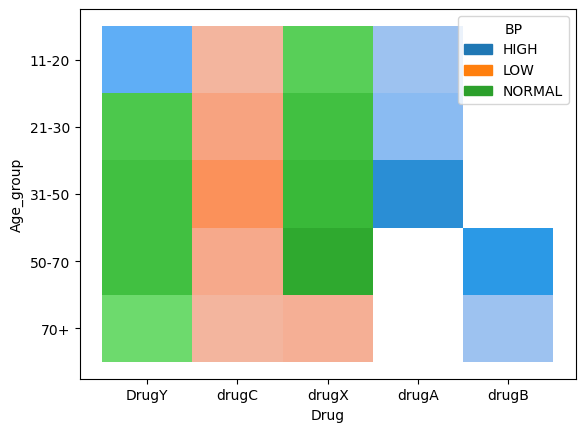

In [15]:
sns.histplot(data=df_age_grp,y='Age_group',x='Drug',hue='BP')

Text(0.5, 1.0, 'relation Na_to_K vs Drug')

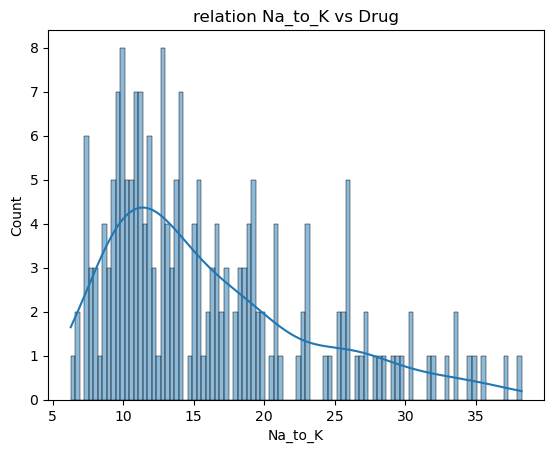

In [16]:
sns.histplot(x=df_age_grp['Na_to_K'],bins=100,kde=True)
plt.title("relation Na_to_K vs Drug")


<Axes: >

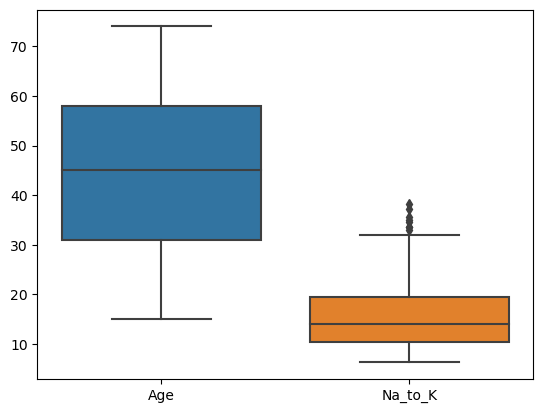

In [17]:
#checking the outliers using box plot

sns.boxplot(data=df_age_grp)

## feature encoding 

In [18]:
df.drop(columns='Sex',inplace=True)

In [19]:
#lets do one hot encoding for all category columns
BP_dummies= pd.get_dummies(data=df,columns=['BP'],prefix='BP')
BP_dummies['Cholesterol']=BP_dummies['Cholesterol'].map({'HIGH':1,"NORMAL":0})

In [20]:
df_encoded= BP_dummies.copy()
df_encoded

,Age,Cholesterol,Na_to_K,Drug,BP_HIGH,BP_LOW,BP_NORMAL
0,23,1,25.355,DrugY,True,False,False
1,47,1,13.093,drugC,False,True,False
2,47,1,10.114,drugC,False,True,False
3,28,1,7.798,drugX,False,False,True
4,61,1,18.043,DrugY,False,True,False
...,...,...,...,...,...,...,...
195,56,1,11.567,drugC,False,True,False
196,16,1,12.006,drugC,False,True,False
197,52,1,9.894,drugX,False,False,True
198,23,0,14.020,drugX,False,False,True


In [21]:
df_encoded.to_csv('drug_df_cleaned.csv')


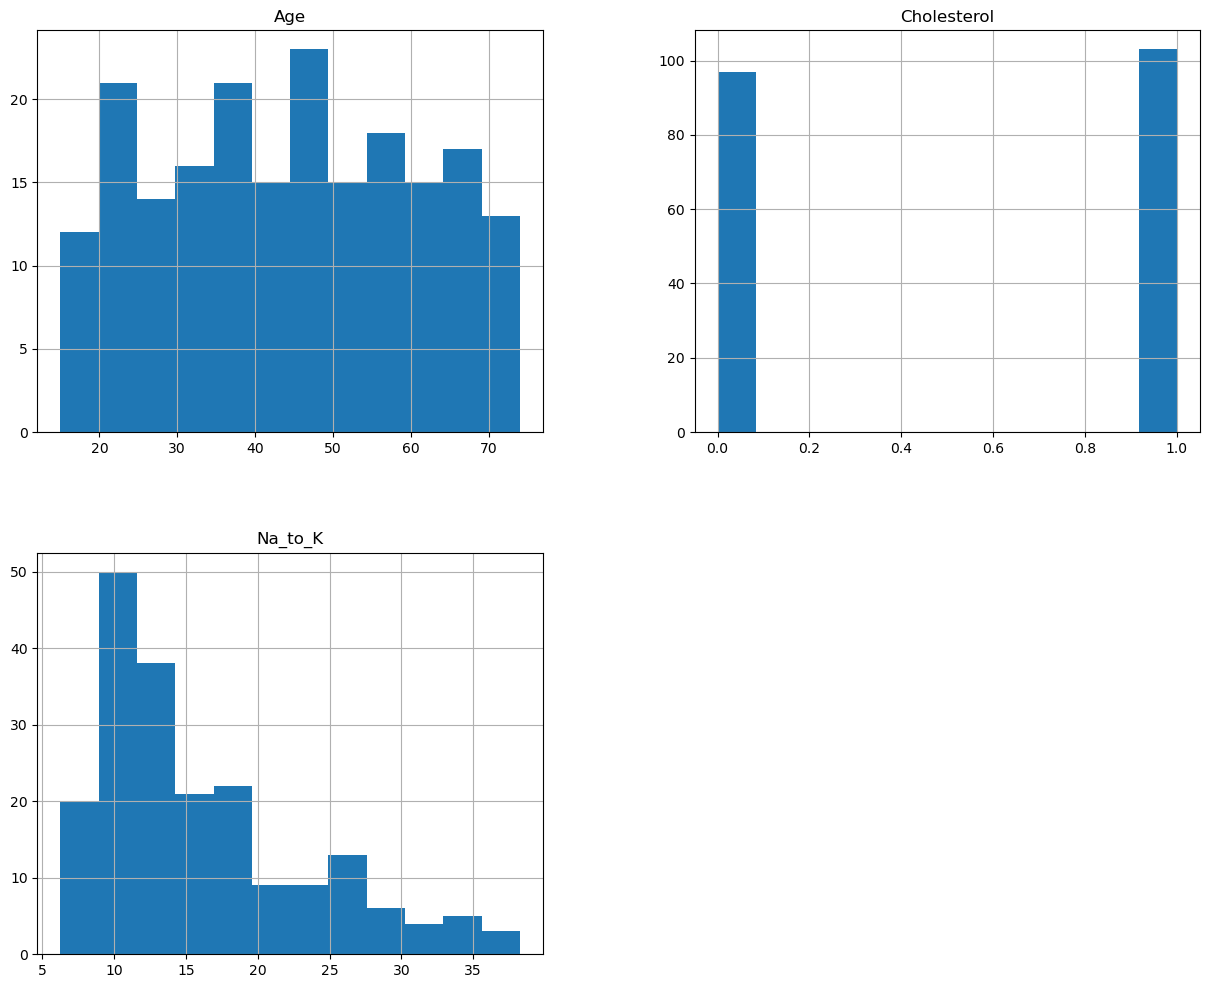

In [22]:
df_encoded.hist(figsize=(15,12),bins=12)
plt.title("features distribution")
plt.show()

In [23]:
X=df_encoded.drop(columns='Drug')
y=df_encoded['Drug']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234)

In [24]:
model= LogisticRegression(multi_class='multinomial',solver='lbfgs')

In [25]:
#standradizing the values for same scale 


sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)


In [26]:
model.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial')

In [27]:
model.coef_

array([[ 0.00996371, -0.28124591,  3.9924242 , -0.18517416, -0.081326  ,
         0.28834377],
       [-0.90484888,  0.30626797, -1.39410438,  1.21384386, -0.67774669,
        -0.61379975],
       [ 1.40622249, -0.0845907 , -0.33476507,  1.05755599, -0.70442689,
        -0.41466481],
       [-0.47507312,  1.25268591, -1.13564312, -0.57907877,  1.12564258,
        -0.55288587],
       [-0.03626419, -1.19311726, -1.12791163, -1.50714692,  0.337857  ,
         1.29300666]])

In [28]:
df_coeff=pd.DataFrame({'Feature':X.columns,'COEFF':model.coef_[0]})
df_coeff

,Feature,COEFF
0,Age,0.009964
1,Cholesterol,-0.281246
2,Na_to_K,3.992424
3,BP_HIGH,-0.185174
4,BP_LOW,-0.081326
5,BP_NORMAL,0.288344


In [29]:
#lets check for multicollinearity using perturbation test
w=model.coef_

#introduce noise
epilson=0.0005
X_=X_train+epilson

In [30]:
model_perturb=LogisticRegression(multi_class='multinomial',solver='lbfgs')
model_perturb.fit(X_,y_train)
w_=model_perturb.coef_

In [31]:
small_number=0.0000001
w_=w_+small_number
w=w+small_number

change= (abs((w-w_)/(w))*100)[0]




In [32]:
dict(zip(X.columns,change.round(4)))

{'Age': 0.0218,
 'Cholesterol': 0.0024,
 'Na_to_K': 0.0002,
 'BP_HIGH': 0.0007,
 'BP_LOW': 0.0084,
 'BP_NORMAL': 0.0001}

##### inference-  no multicollinearity exist

## lets predict the test data on model

In [33]:
y_pred0=model.predict(X_test)


In [34]:
#letc check the accuracy of the model

#ACCURACY

score_lr= model.score(X_test,y_test)
print(score_lr)

0.975


In [35]:
y.value_counts().index

Index(['DrugY', 'drugX', 'drugA', 'drugC', 'drugB'], dtype='object', name='Drug')

In [36]:
actual=y_test
predicted=y_pred0
results= confusion_matrix(actual,predicted,labels=y.value_counts().index)
print("Confusion matrix")
print(results)

Confusion matrix
[[19  0  0  0  0]
 [ 0 10  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  0  4  0]
 [ 0  0  1  0  3]]


##### inference 
1) DRUG Y
TP =  19 ,
TN= (10+4+4+4),
FN= 0,
FP = 0
2) DRUX X
TP= 10,
TN= (19+3+4+4),
FN= 0,
FP= 0

model has predicted correctly

In [37]:
#lets calculate recall(TPR) and precision

from sklearn.metrics import classification_report

print(classification_report(actual,predicted,target_names=y_test.value_counts().index))

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        19
       drugX       0.75      1.00      0.86         3
       drugB       1.00      0.75      0.86         4
       drugC       1.00      1.00      1.00         4
       drugA       1.00      1.00      1.00        10

    accuracy                           0.97        40
   macro avg       0.95      0.95      0.94        40
weighted avg       0.98      0.97      0.97        40




## class imbalance using SMOTE
by default SMOTE will oversample all classes to have the same number of classes equal as the class with the most examples

In [38]:
y.value_counts()

Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

In [39]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)
X_train

array([[-0.71529099,  0.93933644,  2.57283241, -0.77459667,  1.46193533,
        -0.6644106 ],
       [ 0.25975956, -1.06458129, -0.99509935,  1.29099445, -0.68402479,
        -0.6644106 ],
       [-1.50751956, -1.06458129, -0.9114647 , -0.77459667, -0.68402479,
         1.50509339],
       [ 1.23481011, -1.06458129,  2.34107375,  1.29099445, -0.68402479,
        -0.6644106 ],
       [ 0.1988189 ,  0.93933644, -0.08303546, -0.77459667,  1.46193533,
        -0.6644106 ],
       [ 0.01599692, -1.06458129, -0.80551789, -0.77459667,  1.46193533,
        -0.6644106 ],
       [ 0.80822549, -1.06458129, -0.19776319,  1.29099445, -0.68402479,
        -0.6644106 ],
       [-0.83717231, -1.06458129, -0.53863555,  1.29099445, -0.68402479,
        -0.6644106 ],
       [ 0.62540352, -1.06458129, -1.20224265, -0.77459667, -0.68402479,
         1.50509339],
       [-1.01999429,  0.93933644,  0.58474617, -0.77459667, -0.68402479,
         1.50509339],
       [ 1.53951341,  0.93933644, -0.8297014 ,  1.

In [40]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy='not majority')
X_sm,y_sm=smote.fit_resample(X_train,y_train)
y_sm.value_counts()


Drug
DrugY    68
drugA    68
drugX    68
drugB    68
drugC    68
Name: count, dtype: int64

##### inferene- we have sampled all the minority class except majority class,here majjority class was Drug Y 

In [41]:
#always first split teh data into train_test then stanrdize them using any method and the resample the train data

In [42]:
#model building

lr=LogisticRegression(multi_class='multinomial',solver='lbfgs')

In [43]:
lr.fit(X_sm,y_sm)

LogisticRegression(multi_class='multinomial')

In [44]:
lr.coef_

array([[-0.07769676, -0.42787094,  4.97381581, -0.25773204, -0.05228537,
         0.32355667],
       [-1.72949198,  0.34016745, -1.52883288,  1.54266227, -0.78183074,
        -0.82985997],
       [ 2.2782758 , -0.20756083, -0.82731645,  1.35235119, -0.99128813,
        -0.41821958],
       [-0.5745512 ,  1.75853255, -1.63227416, -0.82123896,  1.55431308,
        -0.70881315],
       [ 0.10346415, -1.46326823, -0.98539232, -1.81604246,  0.27109116,
         1.63333601]])

In [45]:
df_coeff= pd.DataFrame({"columns": X.columns,"coeff": lr.coef_[0]})
df_coeff

,columns,coeff
0,Age,-0.077697
1,Cholesterol,-0.427871
2,Na_to_K,4.973816
3,BP_HIGH,-0.257732
4,BP_LOW,-0.052285
5,BP_NORMAL,0.323557


#### 

#### lets check evaluation metrics

In [56]:
from sklearn.metrics import accuracy_score,roc_auc_score,plot_roc_curve
def compute_evaluation_metric(model,X_test,y_actual,y_pred,y_pred_prob):
    cm=confusion_matrix(y_actual,y_pred,labels=y.value_counts().index)
    print(f"confusion matrix -\n {cm}\n")
    print(f"accuracy score : {accuracy_score(y_actual,y_pred)}")
    print(f"macro averaged OvR AUC score : {roc_auc_score(y_actual,y_pred_prob,multi_class='ovr',average='macro')}")
    #way to find entire multiclass confusion matrix
    TP=(np.diag(cm))
    
    FP=(cm.sum(axis=0)-np.diag(cm))
    #print(FP)
    FN=(cm.sum(axis=1)-np.diag(cm))
    #print(FN)
    #print(f"cm sum -{cm.sum()}")
    TN=cm.sum()-(FP+FN+TP)
    #print(TN)
    
    TPR=np.round(np.mean(TP/(TP+FN)),4)
    FNR=np.round(np.mean(FN/(TP+FN)),4)
    TNR=np.round(np.mean(TN/(TN+FP)),4)
    FPR=np.round(np.mean(FP/(FP+TN)),4)
    print(f"TPR/Recall is {TPR}")
    print(f"TNR/Specifity is {TNR}")
    print(f"FNR is {FNR}")
    print(f"FPR is {FPR}" )
    print(f"\n classification report - :\n {classification_report(y_actual,y_pred)}")
    #plot_roc_curve(model,y_actual,y_pred_prob)
    #plt.show()

In [57]:
y_pred=lr.predict(X_test)
y_pred_prob=lr.predict_proba(X_test)
#y_pred_prob=[x[1] for x in y_pred_prob]

compute_evaluation_metric(lr,X_test,y_test,y_pred,y_pred_prob)


confusion matrix -
 [[18  3  2  0  0]
 [ 0  9  0  0  0]
 [ 0  0  1  0  1]
 [ 0  0  0  3  0]
 [ 0  0  0  0  3]]

accuracy score : 0.85
macro averaged OvR AUC score : 0.9925863044708546
TPR/Recall is 0.8565
TNR/Specifity is 0.9647
FNR is 0.1435
FPR is 0.0353

 classification report - :
               precision    recall  f1-score   support

       DrugY       1.00      0.78      0.88        23
       drugA       0.33      0.50      0.40         2
       drugB       0.75      1.00      0.86         3
       drugC       1.00      1.00      1.00         3
       drugX       0.75      1.00      0.86         9

    accuracy                           0.85        40
   macro avg       0.77      0.86      0.80        40
weighted avg       0.89      0.85      0.86        40



### ROC curves are typically used in binary classification, where the TPR and FPR can be defined unambiguously. In the case of multiclass classification, a notion of TPR or FPR is obtained only after binarizing the output. This can be done in 2 different ways:

the One-vs-Rest scheme compares each class against all the others (assumed as one);

the One-vs-One scheme compares every unique pairwise combination of classes. 

In [58]:
y_train

24     DrugY
150    drugA
114    drugX
33     DrugY
23     DrugY
       ...  
17     drugA
98     DrugY
66     drugA
126    DrugY
109    DrugY
Name: Drug, Length: 160, dtype: object

In [59]:
y_test

50     DrugY
127    drugX
37     drugX
149    drugC
19     DrugY
104    DrugY
179    DrugY
53     DrugY
162    drugX
158    drugC
82     drugC
185    DrugY
182    drugX
189    DrugY
108    drugB
31     drugB
4      DrugY
178    DrugY
121    DrugY
20     DrugY
172    DrugY
88     DrugY
166    DrugY
170    drugX
128    DrugY
72     drugX
180    DrugY
26     DrugY
144    drugA
52     DrugY
79     drugX
93     DrugY
183    DrugY
119    DrugY
85     drugB
133    DrugY
184    DrugY
139    drugX
95     drugX
140    drugA
Name: Drug, dtype: object

In [60]:
#converting class labels to integers
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer().fit(y_train)
y_encode_test=lb.transform(y_test)

In [55]:
y_encode_test

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [49]:
y_encode_test.shape #(n_samples,n_classes)


(40, 5)

In [54]:
# for each classs in multiclass find ROC and Confusionmatrix parameters
for clss in lb.classes_:
    print(f"class - {clss}")
    print(f"TP {clss} - {sum([1 if ((i==clss) & (j==clss)) else 0 for (i,j) in zip(y_test,y_pred)])}")
    print(f"FP {clss} - {sum([1 if ((i!=clss) & (j==clss)) else 0 for (i,j) in zip(y_test,y_pred)])}")
    print(f"TN {clss} - {sum([1 if ((i!=clss) & (j!=clss)) else 0 for (i,j) in zip(y_test,y_pred)])}")
    print(f"FN {clss} - {sum([1 if ((i==clss) & (j!=clss)) else 0 for (i,j) in zip(y_test,y_pred)])}")
    #print(f"TPR is {np.mean(TP/(TP+FN))}")
    #print(f"TNR is {np.mean(TN/(TN+FP))}")
    print(f"")
    classid=np.flatnonzero(lb.classes_==clss)[0]
    print(classid)
    print(y_encode_test[:,classid])
    roc=roc_auc_score(
        y_encode_test[:,classid],
        y_pred_prob[:,classid],
        multi_class='ovr',
        average='micro',
    )
    print(f"Mirco-averaged one vs rest ROC AUC score for classid {classid} is {roc}")

class - DrugY
TP DrugY - 18
FP DrugY - 0
TN DrugY - 17
FN DrugY - 5

0
[1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1
 0 0 0]
Mirco-averaged one vs rest ROC AUC score for classid 0 is 1.0
class - drugA
TP drugA - 1
FP drugA - 2
TN drugA - 36
FN drugA - 1

1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1]
Mirco-averaged one vs rest ROC AUC score for classid 1 is 0.9736842105263158
class - drugB
TP drugB - 3
FP drugB - 1
TN drugB - 36
FN drugB - 0

2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0]
Mirco-averaged one vs rest ROC AUC score for classid 2 is 1.0
class - drugC
TP drugC - 3
FP drugC - 0
TN drugC - 37
FN drugC - 0

3
[0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Mirco-averaged one vs rest ROC AUC score for classid 3 is 1.0
class - drugX
TP drugX - 9
FP drugX - 3
TN drugX - 28
FN drugX - 0

4
[0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0

### TPR,TNR,FNR,FPR for multiclass problem


In [200]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[18,  2,  0,  0,  3],
       [ 0,  2,  0,  0,  0],
       [ 0,  0,  3,  0,  0],
       [ 0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  9]], dtype=int64)

In [201]:
TP=np.diag(cm).astype(float)
TP

array([18.,  2.,  3.,  3.,  9.])

In [202]:
FN=cm.sum(axis=1)-np.diag(cm)
FN

array([5, 0, 0, 0, 0], dtype=int64)

In [203]:
FP=cm.sum(axis=0)-np.diag(cm)
FP.sum()

5

In [204]:
TN= cm.sum()-(FP+FN+TP)
TN

array([17., 36., 37., 37., 28.])